In [1]:
### Download the dataset MNIST
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
### Look at the arrays

X, y = np.array(mnist["data"]), np.array(mnist["target"])
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


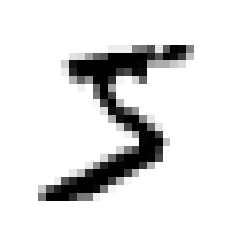

In [4]:
### show image

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

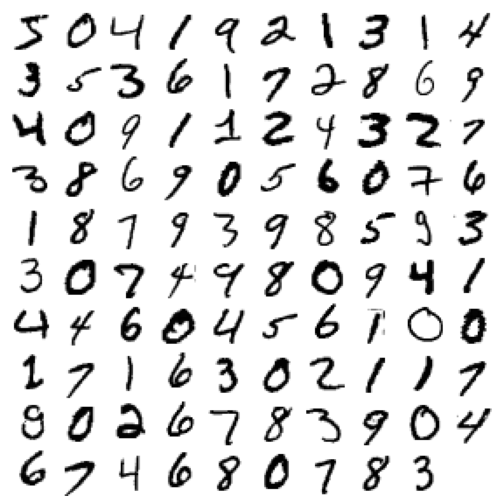

In [6]:
plt.figure(figsize=(9,9))
example_images = X[:99]
plot_digits(example_images, images_per_row=10)
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images)

The training set is already shuffled for us, which is good as this guarantees that all
cross-validation folds will be similar (you don’t want one fold to be missing some digits).

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [10]:
### 5-detector

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

now let’s pick a classifier and train it. A good place to start is with a Stochastic
Gradient Descent (SGD) classifier.

This classifier
has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently

In [11]:
### SGD Classifier

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

#### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation

split the data which is from training set into train fold and validation fold

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

# Clone the model base
clone_clf = clone(sgd_clf)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    # Train folds
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    # validation folds
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    # fit the model
    clone_clf.fit(X_train_folds, y_train_folds)
    
    # predict
    y_pred = clone_clf.predict(X_test_fold)
    
    # Accuracy
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [14]:
### a simple way to do the cross_val_score

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

### Confusion Matrix

In [15]:
### Do the cross validation then predict the answer

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class.  
each column represents a predicted class.  

Left top is True Negative  
Right top is False Positive  
Left bottom is False Negative  
Right bottom is True Positive  

Precision = TP/(TP+FP)  
Recall = TP/(TP+FN)  

### Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score
print('Precision = ', precision_score(y_train_5, y_train_pred))
print('Recall = ', recall_score(y_train_5, y_train_pred))

Precision =  0.8370879772350012
Recall =  0.6511713705958311


In [18]:
### F1 score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

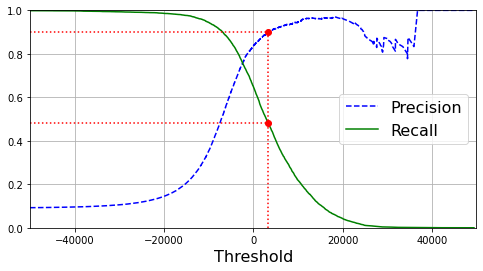

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

### ROC Curve

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

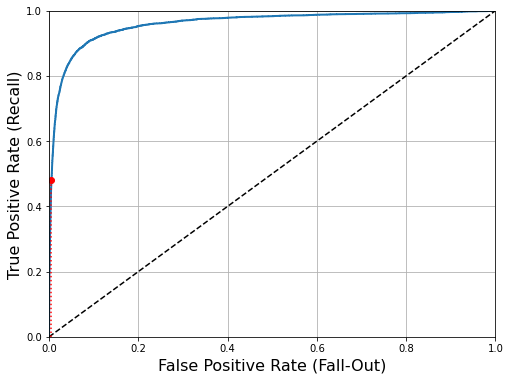

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Compare with RandomForestClassifier

In [24]:
'''
the RandomForestClassifier class does not have a decision_function() method. 
Instead it has a predict_proba() method.
'''

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [25]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

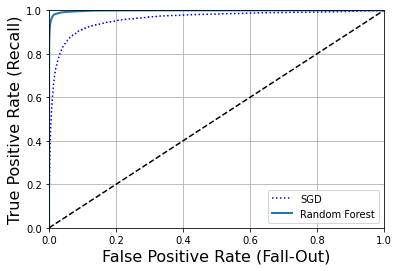

In [26]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [28]:
### One vs All

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [29]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [30]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

3

In [31]:
### One vs One

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
len(ovo_clf.estimators_)

45

In [33]:
### RandomForest

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [35]:
### Cross validation

cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

In [36]:
### Standard scaler sometimes can improve the performence

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.96445, 0.96255, 0.96645])

### Error Analysis

In [37]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv= 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5840,    1,    8,    2,    4,    9,   20,    1,   35,    3],
       [   1, 6634,   43,   12,   13,    5,    6,   13,   12,    3],
       [  26,   12, 5749,   29,   32,    5,   20,   37,   42,    6],
       [   7,    7,   93, 5809,    3,   63,    7,   49,   61,   32],
       [  12,   13,   14,    1, 5643,    0,   29,   14,   17,   99],
       [  20,    9,    9,   65,   13, 5195,   53,    6,   32,   19],
       [  25,   11,    5,    0,   12,   45, 5805,    0,   15,    0],
       [   4,   24,   58,    6,   37,    1,    0, 6037,   11,   87],
       [   9,   35,   44,   53,   26,   52,   27,    5, 5524,   76],
       [  21,   10,   13,   76,   75,   15,    3,   58,   45, 5633]],
      dtype=int64)

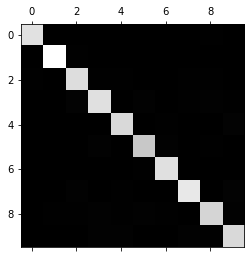

In [38]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

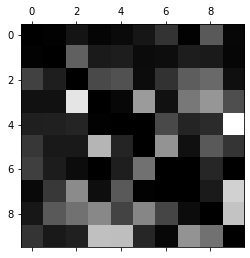

In [39]:
### compare error rates instead of absolute number of errors

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

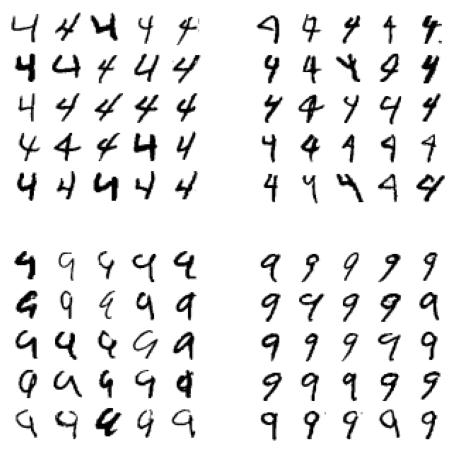

In [40]:
cl_a, cl_b = 4, 9
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [41]:
### Classified the MNIST to large and odd
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [42]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [43]:
### Average F1 Score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### Multioutput Classification

In [44]:
# put some noise into the image and train a model to turn the image back

noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise

noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

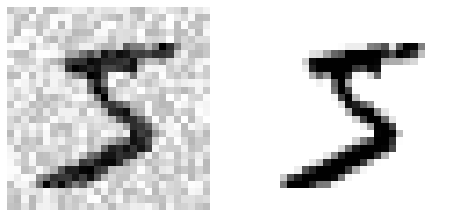

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(121); plt.imshow(X_train_mod[0].reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest");plt.axis("off")
plt.subplot(122); plt.imshow(X_train[0].reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest");plt.axis("off")
plt.show()

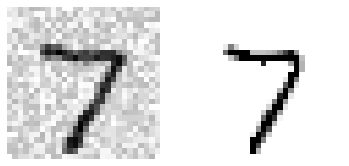

In [46]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])

plt.subplot(121);plt.imshow(X_test_mod[0].reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest");plt.axis("off")
plt.subplot(122);plt.imshow(clean_digit.reshape(28,28), cmap = mpl.cm.binary, interpolation="nearest");plt.axis("off")
plt.show()

## Exercise

### An MNIST Classifier With Over 97% Accuracy

In [47]:
### Check RandomForest accuracy

from sklearn.metrics import accuracy_score

X_test_scale = scaler.transform(X_test)
y_test_pred = forest_clf.predict(X_test_scale)
print(accuracy_score(y_test,y_test_pred))

0.3783


In [48]:
### Use KNeighbor + GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


### Param Grid
param_grid = [{'n_neighbors': [3,4,5],
              'weights': ['uniform','distance'],
              }]

knn_clf = KNeighborsClassifier()

### Scaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# Search best param
knn_gridsearch = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  19.3s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time= 1.4min
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  18.1s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  16.1s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  16.7s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  16.9s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  16.2s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  17.7s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  16.1s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  15.9s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  20.1s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [49]:
knn_gridsearch.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [50]:
from sklearn.metrics import accuracy_score

#X_test_scaled = scaler.fit_transform(X_test)

y_pred = knn_gridsearch.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

### Data Augmentation

In [51]:
from scipy.ndimage.interpolation import shift

In [52]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

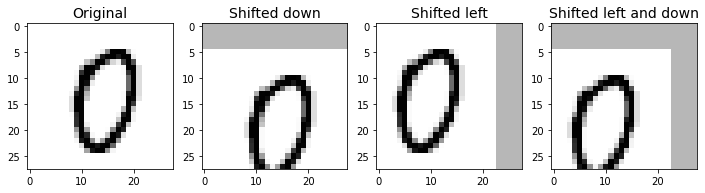

In [53]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))

def shift_plot(image, dx, dy, title, fontsize, cnew):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=cnew, mode="constant")
    plt.title(title, fontsize=fontsize)
    plt.imshow(shifted_image.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(141); shift_plot(X_train[1000], 0, 0, "Original", 14, 0)
plt.subplot(142); shift_plot(X_train[1000], 0, 5, "Shifted down", 14, 100)
plt.subplot(143); shift_plot(X_train[1000], -5, 0, "Shifted left", 14, 100)
plt.subplot(144); shift_plot(X_train[1000], -5, 5, "Shifted left and down", 14, 100)
plt.show()

In [76]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [77]:
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [78]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [79]:
# Use ** symbol, let the gridsearch.best_params_ put into the KNeighborsClassifier class

knn_clf = KNeighborsClassifier(**knn_gridsearch.best_params_)

In [80]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [81]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9777